# Robust estimation with optimization functionals with Chirho

## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
from typing import Callable, Optional, Tuple

import functools
import torch
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchopt

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
import pyro.contrib.gp as gp

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.robust.internals.utils import ParamDict
from chirho.robust.handlers.estimators import one_step_corrected_estimator, tmle
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.predictive import PredictiveModel, PredictiveFunctional
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood

from docs.examples.robust_paper.models import MultivariateNormalModel


pyro.settings.set(module_local_params=True)

sns.set_style("white")

NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
class ZeroCenteredModel(MultivariateNormalModel):
    def forward(self):
        scale_tril = self.sample_scale_tril()
        pyro.sample("x", dist.MultivariateNormal(loc=torch.zeros(self.p), scale_tril=scale_tril))

        return scale_tril
    
class KnownCovModel(ZeroCenteredModel):
    def __init__(self, p, scale_tril):
        super().__init__(p)
        self.scale_tril = scale_tril

    def sample_scale_tril(self):
        return self.scale_tril
    
class ConditionedModel(ZeroCenteredModel):
    def __init__(self, D_train, include_prior=True):
        self.D_train = D_train
        self.N, p = D_train['x'].shape
        self.include_prior = include_prior
        super().__init__(p)
    
    def forward(self):
        with pyro.poutine.mask(mask=self.include_prior):
            scale_tril = self.sample_scale_tril()
        with pyro.condition(data=self.D_train):
            with pyro.plate(self.N, dim=-2):
                pyro.sample("x", dist.MultivariateNormal(loc=torch.zeros(self.p), scale_tril=scale_tril))
        

In [3]:
# Data configuration
p = 25
alpha = 50
beta = 50
N_train = 500
N_test = 500

# TODO: set this manually
pyro.set_rng_seed(0)
true_scale_tril = pyro.sample("scale_tril", dist.LKJCholesky(p))
# true_scale_tril = torch.eye(p)

true_model = KnownCovModel(p, true_scale_tril)

def generate_data(N_train, N_test):
    # Generate data
    D_train = Predictive(
        true_model, num_samples=N_train, return_sites=["x"]
    )()
    D_test = Predictive(
        true_model, num_samples=N_test, return_sites=["x"]
    )()
    return D_train, D_test

### Fit parameters via maximum likelihood

In [4]:
def MLE(D_train, n_steps=1000, include_prior=True):
    # Fit model using maximum likelihood
    conditioned_model = ConditionedModel(D_train, include_prior=include_prior)
    
    guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
    elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

    # initialize parameters
    elbo()
    adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

    # Do gradient steps
    for _ in range(n_steps):
        adam.zero_grad()
        loss = elbo()
        loss.backward()
        adam.step()

    theta_hat = {
        k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()
    }
    return theta_hat

### Defining the target functional

In [5]:
# Helper class to create a trivial guide that returns the maximum likelihood estimate
class MLEGuide(torch.nn.Module):
    def __init__(self, mle_est: ParamDict):
        super().__init__()
        self.names = list(mle_est.keys())
        for name, value in mle_est.items():
            setattr(self, name + "_param", torch.nn.Parameter(value))

    def forward(self, *args, **kwargs):
        for name in self.names:
            value = getattr(self, name + "_param")
            pyro.sample(
                name, pyro.distributions.Delta(value, event_dim=len(value.shape))
            )

In [6]:
class MarkowitzFunctional(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, scale_tril=None):
        if scale_tril is None:
            scale_tril = self.model()
        cov = scale_tril.mm(scale_tril.T)
        cov_inv = torch.inverse(cov)
        one_vec = torch.ones(cov_inv.shape[0])
        num = cov_inv.mv(one_vec)
        den = one_vec.dot(num)
        return num/den

optimal_weights = MarkowitzFunctional(None)(true_scale_tril)


In [7]:
optimal_weights

tensor([ 0.0072,  0.0949,  0.0397,  0.2320,  0.0390, -0.0013, -0.0164,  0.2619,
        -0.0973,  0.1266,  0.1220, -0.0946,  0.2408, -0.0671, -0.0729, -0.0603,
         0.0012,  0.0739, -0.1326, -0.0098, -0.0712,  0.1233,  0.0662,  0.1291,
         0.0655])

In [8]:
# D_train, D_test = generate_data(N_train, N_test)

# theta_hat = MLE(D_train)

# theta_hat = {
#     k: v.clone().detach().requires_grad_(True) for k, v in theta_hat.items()
# }
# mle_guide = MLEGuide(theta_hat)
# model = PredictiveModel(ZeroCenteredModel(p), mle_guide)

# eif_fn = influence_fn(MarkowitzFunctional, D_test, num_samples_outer=100000, pointwise_influence=False)
# correction_estimator = eif_fn(model)
# correction = correction_estimator()
# correction

### Computing automated doubly robust estimators via Monte Carlo

While the doubly robust correction term is known in closed-form for the average treatment effect functional, our `one_step_correction` and `tmle` function in `ChiRho` works for a wide class of other functionals. We focus on the average treatment effect functional here so that we have a ground truth to compare `one_step_correction` against the plug in estimates.

In [9]:
import json
import os

# Compute doubly robust ATE estimates using both the automated and closed form expressions
N_datasets = 20


# Estimators to compare
estimators = {"one_step": one_step_corrected_estimator}
estimator_kwargs = {
    "one_step": {}
}

# Influence functions
influences = {"monte_carlo_eif": influence_fn}

# Cache the results
RESULTS_PATH = "../results/opt_markowitz.json"

if os.path.exists(RESULTS_PATH):
    with open(RESULTS_PATH, "r") as f:
        estimates = json.load(f)
    i_start = len(estimates["plug-in-mle-from-model"]) 
else:
    estimates = {f"{influence}-{estimator}": [] for influence in influences.keys() for estimator in estimators.keys()}
    estimates["plug-in-mle-from-model"] = []
    i_start = 0

# optimization functional of interest
functional = MarkowitzFunctional

for i in range(i_start, N_datasets):
    pyro.set_rng_seed(i) # for reproducibility
    print("Dataset", i)
    D_train, D_test = generate_data(N_train, N_test)
    theta_hat = MLE(D_train, include_prior=False)

    theta_hat = {
        k: v.clone().detach().requires_grad_(True) for k, v in theta_hat.items()
    }
    mle_guide = MLEGuide(theta_hat)
    model = PredictiveModel(ZeroCenteredModel(p), mle_guide)
    
    print("plug-in-mle-from-model", i)
    plug_in_estimate = functional(model)().detach()
    plug_in_estimate_list = [e.item() for e in plug_in_estimate]
    estimates["plug-in-mle-from-model"].append(plug_in_estimate_list)

    for estimator_str, estimator in estimators.items():
        for influence_str, influence in influences.items():
            print(estimator_str, influence_str, i)
            estimate = estimator(
                functional, 
                D_test,
                num_samples_outer=max(100000, 100 * p), 
                num_samples_inner=1,
                influence_estimator=influence,
                **estimator_kwargs[estimator_str]
            )(PredictiveModel(ZeroCenteredModel(p), mle_guide))().squeeze().detach()

            # There must be a more concise way...
            estimate_list = [e.item() for e in estimate]

            estimates[f"{influence_str}-{estimator_str}"].append(estimate_list)

    with open(RESULTS_PATH, "w") as f:
        json.dump(estimates, f, indent=4)

In [10]:
{k:[sum(v) for v in val] for k, val in estimates.items()}

{'monte_carlo_eif-one_step': [1.0000000279396772,
  1.0000000838190317,
  0.9999999697320163,
  0.999999935971573,
  1.0000000768341124,
  0.9999999012798071,
  0.9999999338760972,
  0.9999999273568392,
  0.9999999846331775,
  1.0000001098960638,
  1.000000067986548,
  0.9999999878928065,
  1.0000000353902578,
  1.0000000009313226,
  0.9999999874271452,
  0.9999999916180968,
  1.0000000563450158,
  1.0000000125728548,
  1.0000000027939677,
  1.0000000055879354,
  0.9999999664723873,
  1.0000000540167093,
  1.0000000484287739,
  1.000000051688403,
  0.9999999720603228,
  0.9999999473802745,
  0.9999999722931534,
  1.000000017695129,
  0.9999999543651938,
  0.999999986961484,
  1.0000000651925802,
  0.9999999916180968,
  1.0000000479631126,
  1.0000000037252903,
  0.9999999834690243,
  1.000000077765435,
  0.9999999436549842,
  1.0000000318977982,
  1.0000000079162419,
  1.0000000013969839,
  1.0000000884756446,
  0.9999999990686774,
  1.0000001057051122,
  0.9999999965075403,
  0.999999

In [38]:
def mse(weights, optimal_weights=optimal_weights):
    return ((weights - optimal_weights)**2).mean()

def mae(weights, optimal_weights=optimal_weights):
    return torch.abs(weights-optimal_weights).mean()

def relative_root_mse(weights, optimal_weights=optimal_weights):
    return torch.sqrt(((weights - optimal_weights)**2).mean())/torch.sqrt((optimal_weights**2).mean())

def relative_mae(weights, optimal_weights=optimal_weights):
    return torch.abs(weights-optimal_weights).mean()/torch.abs(optimal_weights).mean()

def expected_volatility(weights, scale_tril=true_scale_tril):
    return torch.sqrt(weights @ scale_tril @ scale_tril.T @ weights)

def relative_expected_volatility(weights, scale_tril=true_scale_tril):
    return expected_volatility(weights, scale_tril)/expected_volatility(optimal_weights, scale_tril)

In [39]:
estimates_mse = {k: torch.tensor([mse(torch.tensor(v)) for v in vals]) for (k, vals) in estimates.items()}
estimates_mae = {k: torch.tensor([mae(torch.tensor(v)) for v in vals]) for (k, vals) in estimates.items()}
estimates_relative_mae = {k: torch.tensor([relative_mae(torch.tensor(v)) for v in vals]) for (k, vals) in estimates.items()}
estimates_relative_root_mse = {k: torch.tensor([relative_root_mse(torch.tensor(v)) for v in vals]) for (k, vals) in estimates.items()}
estimates_expected_volatility = {k: torch.tensor([expected_volatility(torch.tensor(v)) for v in vals]) for (k, vals) in estimates.items()}
estimates_relative_expected_volatility = {k: torch.tensor([relative_expected_volatility(torch.tensor(v)) for v in vals]) for (k, vals) in estimates.items()}

In [53]:
# The true treatment effect is 0, so a mean estimate closer to zero is better
results_1 = pd.DataFrame(estimates_relative_expected_volatility)
results_2 = pd.DataFrame(estimates_relative_root_mse)

print("EV", results_1.mean().round(2), "\n")
print("RMSE", results_2.mean().round(2))

EV monte_carlo_eif-one_step    1.86
plug-in-mle-from-model      2.60
dtype: float32 

RMSE monte_carlo_eif-one_step    0.08
plug-in-mle-from-model      0.14
dtype: float32


In [58]:
print("EV", (results_1.std()/(N_datasets**0.5)).round(2), "\n")
print("RMSE", (results_2.std()/(N_datasets**0.5)).round(2))

EV monte_carlo_eif-one_step    0.35
plug-in-mle-from-model      0.35
dtype: float32 

RMSE monte_carlo_eif-one_step    0.02
plug-in-mle-from-model      0.02
dtype: float32


In [29]:
# The true treatment effect is 0, so a mean estimate closer to zero is better
results = pd.DataFrame(estimates_relative_root_mse)
results.describe().round(5)

,monte_carlo_eif-one_step,plug-in-mle-from-model
count,50.00000,50.00000
mean,0.07710,0.13518
std,0.09951,0.09249
min,0.00504,0.02069
25%,0.01625,0.04987
50%,0.03924,0.10729
75%,0.08816,0.21390
max,0.58151,0.35913


/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sam-basis/opt/anaconda3/envs/chirho-dynamic/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

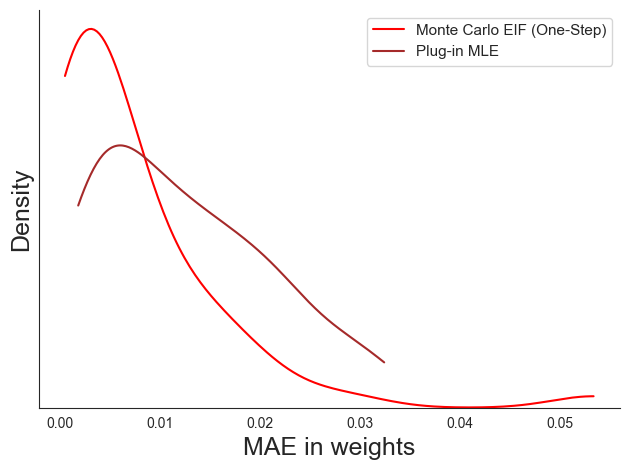

In [14]:
# Visualize the results
fig, ax = plt.subplots()

# # TMLE
# sns.kdeplot(
#     estimates['analytic_eif-tmle'], 
#     label="Analytic EIF (TMLE)",
#     ax=ax,
#     color='blue',
#     linestyle='--'
# )

# sns.kdeplot(
#     estimates['monte_carlo_eif-tmle'], 
#     label="Monte Carlo EIF (TMLE)",
#     ax=ax,
#     color='blue'
# )

# # One-step
# sns.kdeplot(
#     estimates['analytic_eif-one_step'], 
#     label="Analytic EIF (One-Step)",
#     ax=ax,
#     color='red',
#     linestyle='--'
# )

sns.kdeplot(
    estimates_mae['monte_carlo_eif-one_step'], 
    label="Monte Carlo EIF (One-Step)",
    ax=ax,
    color='red',
    cut=0
)

# # DoubleML
# sns.kdeplot(
#     estimates['analytic_eif-double_ml'], 
#     label="Analytic EIF (DoubleML)",
#     ax=ax,
#     color='green',
#     linestyle='--'
# )

# sns.kdeplot(
#     estimates['monte_carlo_eif-double_ml'], 
#     label="Monte Carlo EIF (DoubleML)",
#     ax=ax,
#     color='green'
# )

# Plug-in MLE
sns.kdeplot(
    estimates_mae['plug-in-mle-from-model'], 
    label="Plug-in MLE",
    ax=ax,
    color='brown',
    cut=0
)

ax.set_yticks([])
sns.despine()
ax.set_xlabel("MAE in weights", fontsize=18)
ax.set_ylabel("Density", fontsize=18)

ax.legend(loc="upper right", fontsize=11)

plt.tight_layout()

plt.savefig('figures/markowitz_optimal.png')

## References

Kennedy, Edward. "Towards optimal doubly robust estimation of heterogeneous causal effects", 2022. https://arxiv.org/abs/2004.14497.